In [1]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.7 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import pandas as pd
import requests

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster, cophenet
import matplotlib.pyplot as plt

#from Bio.Align import PairwiseAligner, substitution_matrices

### Perform pairwise sequence alignment using Biopython

#### I. Obtain protein sequence from UniProt database if it is not already available

For example, the list of targets for Alzheimer's Disease are saved in "AD targets_ID.csv"

In [8]:
targets = pd.read_csv("/ccs/proj/gen243/nina23bom/Target_Information/AD targets_ID.csv")

In [5]:
def Get_Sequence(Uniprot_ID):
    response = requests.get(f"https://rest.uniprot.org/uniprotkb/{Uniprot_ID}.fasta")
    #if response.status_code == 200:
    #    with open(target_path+f"{Uniprot_ID}.fasta", 'w') as file:
    #        file.write(response.text)
    #else:
    #    print(f"Failed to retrieve Uniprot ID: {Uniprot_ID}")
        
    splitted_sequences = response.text.split('\n')
    filtered_sequences = [sequence for sequence in splitted_sequences 
                         if sequence and not sequence.startswith(">")]
    sequence = "".join(filtered_sequences)
    return sequence

In [9]:
for i in range(targets.shape[0]):
    print(f"Fetching protein sequence for Uniprot = {targets.Uniprot_ID[i]}")
    targets.loc[i, "sequence"] = Get_Sequence(targets.Uniprot_ID[i])
print("All protein sequences were successfully pulled from UniProt database")

Fetching protein sequence for Uniprot = P50406
Fetching protein sequence for Uniprot = Q13639
Fetching protein sequence for Uniprot = P08908
Fetching protein sequence for Uniprot = P22303
Fetching protein sequence for Uniprot = P06276
Fetching protein sequence for Uniprot = P56817
Fetching protein sequence for Uniprot = P05067
Fetching protein sequence for Uniprot = Q00535
Fetching protein sequence for Uniprot = Q16769
Fetching protein sequence for Uniprot = P49841
Fetching protein sequence for Uniprot = P27338
Fetching protein sequence for Uniprot = P35439
Fetching protein sequence for Uniprot = Q9Y233
Fetching protein sequence for Uniprot = P27815
Fetching protein sequence for Uniprot = O76083
Fetching protein sequence for Uniprot = P28845
Fetching protein sequence for Uniprot = Q13093
Fetching protein sequence for Uniprot = O14684
Fetching protein sequence for Uniprot = P17655
Fetching protein sequence for Uniprot = P03951
Fetching protein sequence for Uniprot = Q14416
Fetching prot

In [10]:
targets.to_csv("/ccs/proj/gen243/nina23bom/Target_Information/AD targets_ID.csv", index=False)

#### Bio.Align.PairwiseAligner
Performs pairwise sequence alignment.
Get global and local alignments between two sequences. 

**PairwiseAligner.mode**:
* 'global' - finds the best cocordance between all characters in two sequences. "Needleman-Wunsch" algorithm 
* 'local' - finds just the subsequences that align the best. "Smith-Waterman" algorithm
* 'localms' - performs local alignment with multiple optimal solutions
* 'overlap' - performs an overlap alignment, which is used for comparing two sequences with overlapping regions

In [39]:
def Align_Sequences(SeqA, SeqB, mode = 'local', open_gap_score=-10, extend_gap_score=-0.5):
    # Create the aligner
    aligner=PairwiseAligner()
    # Use the BLOSUM62 matrix
    aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
    # Set aligner parameters
    aligner.mode = mode
    aligner.open_gap_score = open_gap_score
    aligner.extend_gap_score = extend_gap_score

    alignments = aligner.align(SeqA, SeqB)
    aligned_seq1, aligned_seq2 = alignments[0]
    identity = sum(a == b for a, b in zip(aligned_seq1, aligned_seq2)) / len(aligned_seq1)
    
    return identity
    

#### Example of perform sequence alignment:

In [40]:
seq1 = targets.sequence[0]
seq2 = targets.sequence[1]
Align_Sequences(seq1, seq2)

0.32934131736526945

#### Calculate the similarity matrix of a set of targets, and perform hierarchical analysis and display dendrogram

In [44]:
total = []
for i in range(len(targets.sequence)):
    row = []
    for j in range(len(targets.sequence)):
        row.append(Align_Sequences(targets.sequence[i], targets.sequence[j]))
    total.append(row)

In [45]:
# Display similarity matrix 
SM_df = pd.DataFrame(total, index=targets.Uniprot_ID, columns=targets.Uniprot_ID)
SM_df.style.background_gradient(cmap='Blues')

Uniprot_ID,P50406,Q13639,P08908,P22303,P06276,P56817,P05067,Q00535,Q16769,P49841,P27338,P35439,Q9Y233,P27815,O76083,P28845,Q13093,O14684,P17655,P03951,Q14416,P41594,Q03181,Q12866,P37840,P10636,Q13546,Q5BJF2,O14920
Uniprot_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P50406,1.000000,0.329341,0.285714,0.221053,0.215909,0.306452,0.350000,0.221519,0.250000,0.270270,0.333333,0.206107,0.247423,0.272727,0.357143,0.230769,0.202312,0.221557,0.293478,0.281690,0.213514,0.191651,0.242857,0.210843,0.267857,0.208333,0.234694,0.271186,0.219178
Q13639,0.329341,1.000000,0.323232,0.529412,0.250000,0.190909,0.274725,0.229167,0.256757,0.213836,0.187500,0.217195,0.183099,0.185464,0.222222,0.366667,0.220930,0.200000,0.255319,0.241379,0.182371,0.181416,0.300000,0.228261,0.555556,0.217391,0.236364,0.241071,0.198630
P08908,0.285714,0.323232,1.000000,0.224490,0.186957,0.212644,0.250000,0.178295,0.294118,0.392857,0.202899,0.428571,0.189815,0.195373,0.226027,0.158730,0.212766,0.197279,0.264706,0.200000,0.189024,0.268817,0.271429,0.170732,0.271845,0.222973,0.220126,0.260870,0.263736
P22303,0.234694,0.529412,0.224490,1.000000,0.523490,0.302632,0.233333,0.222892,0.178414,0.264000,0.230769,0.189493,0.234973,0.170000,0.240506,0.203509,0.194226,0.262500,0.175620,0.184100,0.246479,0.203947,0.207921,0.187767,0.285714,0.314286,0.228571,0.269841,0.199446
P06276,0.215909,0.250000,0.186957,0.523490,1.000000,0.205634,0.234568,0.244275,0.272727,0.206522,0.202532,0.216374,0.183824,0.250000,0.291667,0.333333,0.179348,0.388889,0.176039,0.172043,0.225275,0.211009,0.279070,0.209302,0.238095,0.232000,0.204188,0.230769,0.180995
P56817,0.306452,0.190909,0.212644,0.302632,0.205634,1.000000,0.230303,0.263736,0.192982,0.206557,0.228916,0.171220,0.193069,0.184426,0.197080,0.209738,0.179487,0.220183,0.204152,0.202614,0.176329,0.204082,0.240385,0.211628,0.384615,0.217949,0.217822,0.176471,0.204947
P05067,0.350000,0.274725,0.296296,0.233333,0.234568,0.230303,1.000000,0.211823,0.204698,0.179724,0.191667,0.208333,0.195122,0.187500,0.197568,0.189189,0.194539,0.236842,0.167341,0.183824,0.199597,0.274194,0.208333,0.161987,0.227723,0.171488,0.187984,0.500000,0.209366
Q00535,0.221519,0.229167,0.178295,0.222892,0.244275,0.263736,0.211823,1.000000,0.190083,0.348534,0.220183,0.188119,0.188172,0.256098,0.437500,0.310345,0.221053,0.245283,0.223077,0.188976,0.213115,0.181818,0.184502,0.235060,0.272727,0.267606,0.220630,0.205128,0.282392
Q16769,0.250000,0.256757,0.277778,0.178414,0.272727,0.192982,0.204698,0.190083,1.000000,0.186722,0.178744,0.232558,0.193548,0.196133,0.300000,0.212963,0.209150,0.409091,0.223464,0.188172,0.195489,0.186335,0.212766,0.230126,0.202128,0.274194,0.234375,0.300000,0.163043


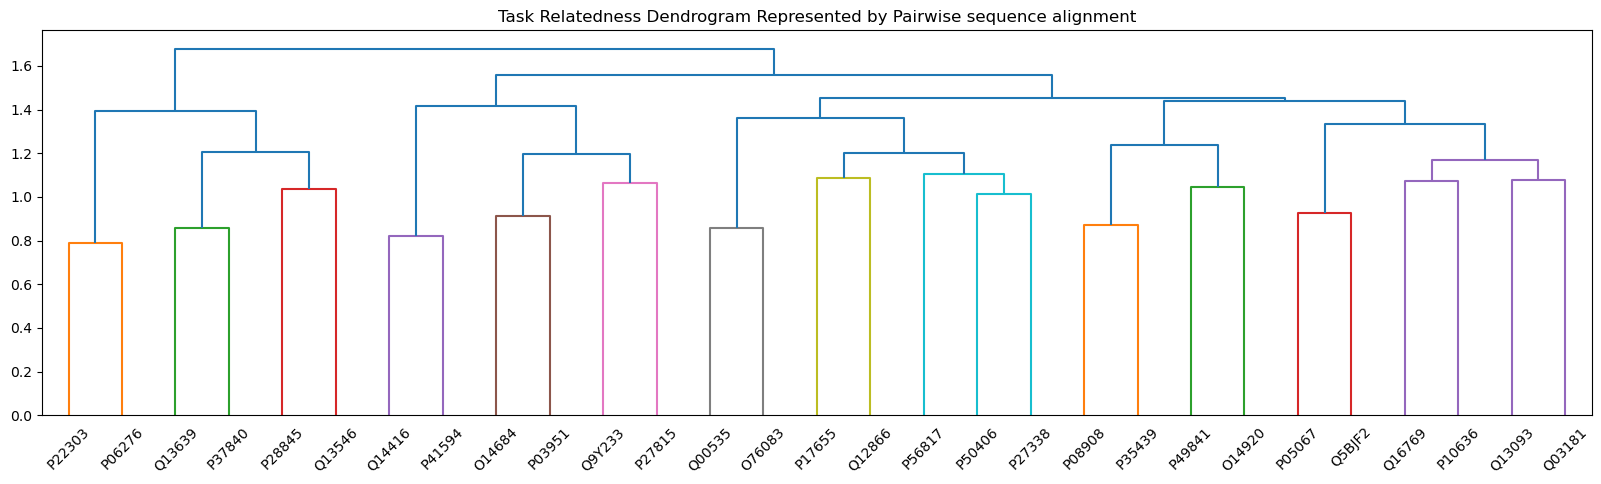

In [46]:
z = linkage(SM_df.values, method = 'ward')
plt.figure(figsize=(20,5))
dn=dendrogram(z,labels = [i for i in targets.Uniprot_ID])
plt.title("Task Relatedness Dendrogram Represented by Pairwise sequence alignment")
plt.show()